[0.96153846 0.96153846 0.97692308 0.96923077 0.96923077 0.98461538
 0.97692308 0.96124031 0.96899225 0.95348837]
[[  22    0    0    0    0]
 [   0   22    0    0    0]
 [   0    0    9    0    0]
 [   0    0    0   37    0]
 [   0    0    0    0 1207]]


Text(0.5, 23.52222222222222, 'Predicted')

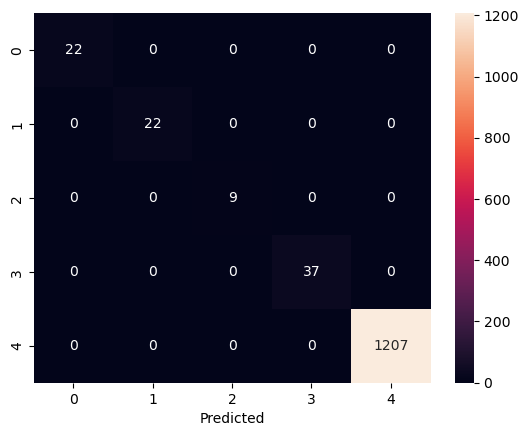

In [10]:
# 不要Warnings
import warnings

warnings.filterwarnings('ignore')

# 导入所需的库
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
import pandas as pd

train_data = pd.read_csv('./dataset/combined_df.csv')
labels = train_data["Class"]
data = train_data.iloc[:, 1:]
data = data.iloc[:, :].values
srf = RF(n_estimators=500, n_jobs=-1)
clf_s = cross_val_score(srf, data, labels, cv=10)
print(clf_s)

# 绘制混淆矩阵
srf.fit(data, labels)
cm = confusion_matrix(labels, srf.predict(data))
print(cm)

import seaborn as sns

sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')

Unique labels: [0 1 2 3 4]
Transformed unique labels: [0. 1.]
train_data shape: (1297, 6035)
Epoch losses: [0.7435953617095947, 0.7402529716491699, 0.7371951341629028, 0.7342560887336731, 0.7314391136169434, 0.72870934009552, 0.726035475730896, 0.7233983874320984, 0.7207869291305542, 0.7181954979896545, 0.7155607342720032, 0.712846040725708, 0.7101332545280457, 0.7074511051177979, 0.7049012184143066, 0.7024073600769043, 0.7001458406448364, 0.6979116201400757, 0.6956785917282104, 0.6934658288955688, 0.6912800669670105, 0.6891160607337952, 0.6869643926620483, 0.6848145127296448, 0.6826688051223755, 0.6805102229118347, 0.6783298850059509, 0.6761271953582764, 0.6738971471786499, 0.6716284155845642, 0.6693071126937866, 0.6669286489486694, 0.6644749045372009, 0.661943793296814, 0.6593588590621948, 0.656725287437439, 0.6540294885635376, 0.6512478590011597, 0.648369550704956, 0.6453869342803955, 0.6422764658927917, 0.6390292644500732, 0.6356444954872131, 0.632104218006134, 0.6283814907073975, 

ValueError: Unknown format code 'd' for object of type 'float'

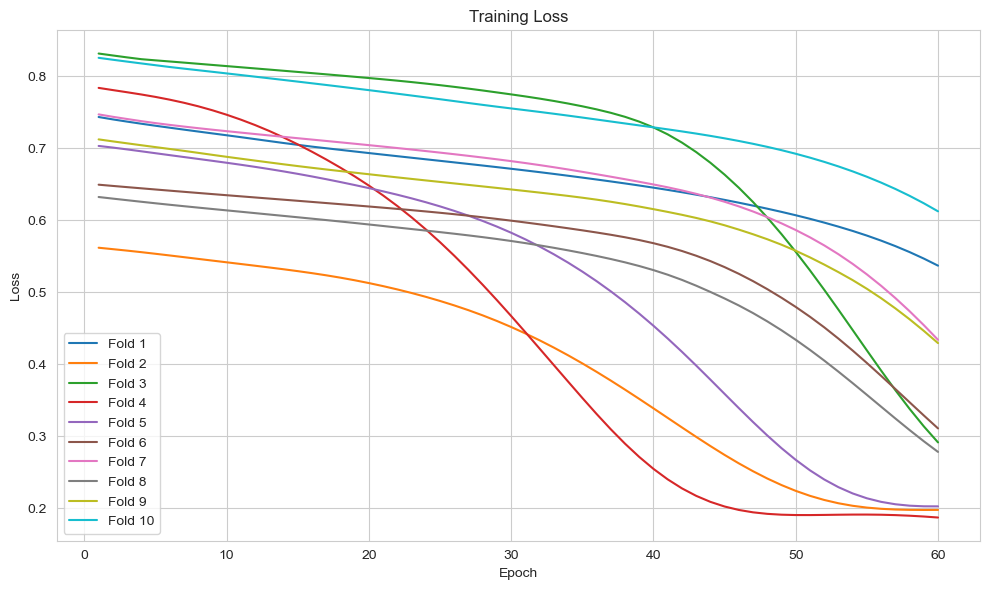

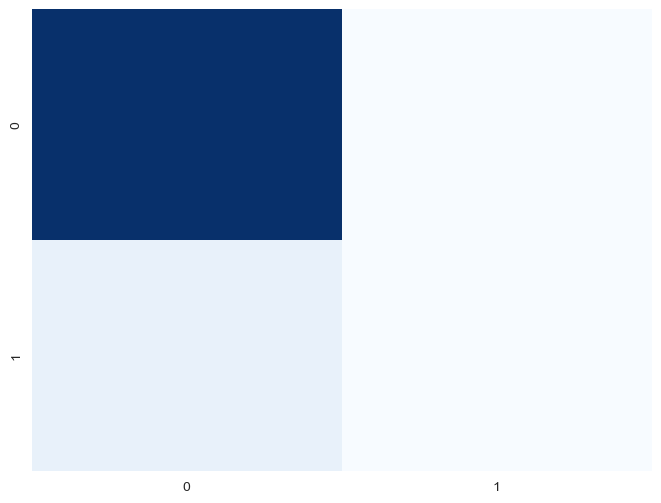

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 读取数据
train_data = pd.read_csv('./dataset/combined_df.csv')
labels = train_data["Class"].values
data = train_data.iloc[:, 1:].values
train_data = data.astype(np.float32)

# 检查标签唯一值
unique_labels = np.unique(labels)
print(f"Unique labels: {unique_labels}")

# 假设是多类别标签，需要二值化（例如，将所有非0的值转换为1）
labels = (labels != 4).astype(np.float32)
unique_labels = np.unique(labels)
print(f"Transformed unique labels: {unique_labels}")

# 确认数据形状
print(f"train_data shape: {train_data.shape}")

# 设置种子和K折交叉验证
seed = 7
np.random.seed(seed)
torch.manual_seed(seed)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
cvscores = []
conf_matrices = []  # 存储混淆矩阵

# 定义模型类
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(train_data.shape[1], 50)  # 调整输入大小
        self.fc2 = nn.Linear(50, 16)
        self.fc3 = nn.Linear(16, 16)
        self.fc4 = nn.Linear(16, 16)
        self.fc5 = nn.Linear(16, 16)
        self.fc6 = nn.Linear(16, 16)
        self.fc7 = nn.Linear(16, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.relu(self.fc5(x))
        x = self.relu(self.fc6(x))
        x = self.sigmoid(self.fc7(x))
        return x

def reset_weights(m):
    """
    重置模型参数
    """
    for layer in m.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()

# 转换数据为Tensor
train_data = torch.tensor(train_data)
labels = torch.tensor(labels).float().view(-1, 1)

# 初始化模型
model = SimpleNN()

# 训练和验证过程
losses = []  # 用于存储每个epoch的损失值

for train_idx, test_idx in kfold.split(train_data, labels):
    # 重置模型参数
    model.apply(reset_weights)

    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    epoch_losses = []  # 存储每个epoch的损失值

    # 训练模型
    for epoch in range(60):
        model.train()
        optimizer.zero_grad()
        outputs = model(train_data[train_idx])
        loss = criterion(outputs, labels[train_idx])
        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.item())  # 记录当前epoch的损失值
    
    losses.append(epoch_losses)  # 记录每折交叉验证的损失曲线
    print(f"Epoch losses: {epoch_losses}")
    # 验证模型
    model.eval()
    with torch.no_grad():
        outputs = model(train_data[test_idx])
        predicted = (outputs > 0.5).float()
        accuracy = (predicted == labels[test_idx]).float().mean().item()
        cvscores.append(accuracy)
        print(f"Accuracy: {accuracy:.4f}")

        # 计算混淆矩阵
        conf_matrix = confusion_matrix(labels[test_idx].numpy(), predicted.numpy())
        conf_matrices.append(conf_matrix)
    # 保存模型
    torch.save(model.state_dict(), f"./models/model_{kfold.n_splits}_{epoch}.pth")
    
# 绘制损失曲线
plt.figure(figsize=(10, 6))
for i, fold_loss in enumerate(losses):
    plt.plot(range(1, len(fold_loss) + 1), fold_loss, label=f"Fold {i+1}")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()

# 保存损失曲线图像
plt.savefig('./training_loss.png')

# 绘制混淆矩阵热图
avg_conf_matrix = np.mean(conf_matrices, axis=0)
plt.figure(figsize=(8, 6))
sns.heatmap(avg_conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.tight_layout()

# 保存混淆矩阵热图
plt.savefig('./confusion_matrix.png')

# 显示图像
plt.show()

print(f"Cross-validation scores: {cvscores}")

